In [1]:
from datasets import load_dataset

emotions = load_dataset("emotion")

In [2]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [4]:
len(train_ds)

16000

In [5]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [6]:
train_ds.column_names

['text', 'label']

In [7]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [8]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [9]:
train_ds["text"][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

In [10]:
train_ds["label"][:5]

[0, 0, 3, 2, 3]

In [11]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [12]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


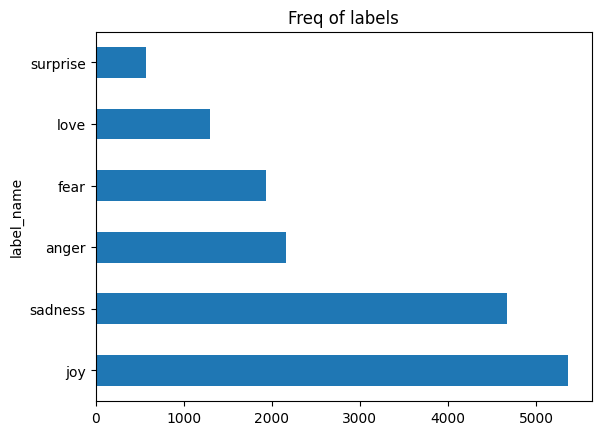

In [13]:
import matplotlib.pyplot as plt

df["label_name"].value_counts().plot.barh()
plt.title("Freq of labels")
plt.show()

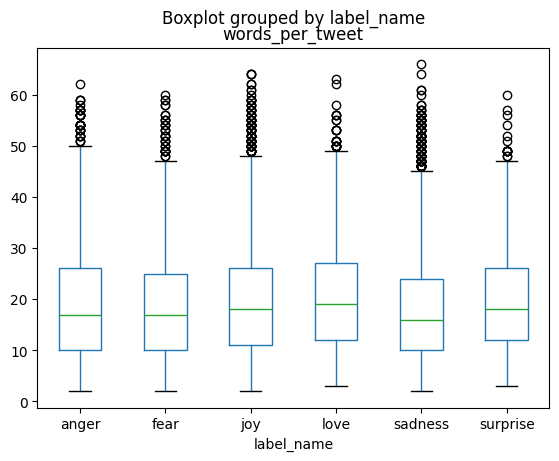

In [14]:
df["words_per_tweet"] = df["text"].str.split().apply(len)
df.boxplot("words_per_tweet", by="label_name", grid = False)
plt.show()

In [15]:
emotions.reset_format()

In [16]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [17]:
def tokenize(batch):
    return tokenizer(batch["text"], padding = True, truncation =  True)

In [18]:
tokenize(emotions["train"][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [19]:
emotions_encoded = emotions.map(tokenize, batched = True, batch_size=None)

In [20]:
emotions_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

In [21]:
import torch
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [22]:
text = "this is a text"

inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [23]:
inputs.items()

dict_items([('input_ids', tensor([[ 101, 2023, 2003, 1037, 3793,  102]])), ('attention_mask', tensor([[1, 1, 1, 1, 1, 1]]))])

In [24]:
inputs = {k : v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.2535, -0.1091,  0.0759,  ..., -0.1054,  0.2257,  0.4615],
         [-0.7154, -0.2742, -0.0954,  ..., -0.3597,  0.5174,  0.3450],
         [-0.4100, -0.2195,  0.1850,  ..., -0.0136,  0.1607,  1.0422],
         [-0.2523, -0.0254,  0.2472,  ..., -0.1637,  0.0865,  1.0516],
         [-0.0570, -0.1057,  0.0662,  ...,  0.0584,  0.1034,  0.2971],
         [ 0.9184,  0.1577, -0.4105,  ...,  0.1509, -0.7327, -0.1572]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [25]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [26]:
outputs.last_hidden_state[:,0]

tensor([[-2.5354e-01, -1.0910e-01,  7.5904e-02, -1.9727e-01, -8.4374e-02,
         -2.4855e-01,  1.2309e-01,  3.3910e-01, -2.6630e-01, -2.6714e-01,
         -1.5949e-01, -1.3243e-01, -2.3409e-01,  1.1643e-01,  1.4593e-02,
          1.3461e-01, -9.9206e-02,  1.5030e-01,  1.3723e-01, -3.6738e-02,
         -1.1725e-02, -1.7942e-01, -5.7122e-02, -2.0161e-01,  8.7641e-02,
         -7.9028e-02, -4.6730e-02, -1.4653e-01, -9.5095e-02, -9.8189e-03,
          5.7143e-02, -3.0236e-03, -5.3867e-02,  6.3477e-02,  6.4599e-02,
         -3.4558e-02, -2.1473e-02,  1.2005e-04,  8.5886e-02, -2.4023e-02,
         -7.1784e-02, -4.4203e-02,  2.1095e-01,  8.8243e-03,  7.8982e-02,
         -5.2531e-02, -1.9031e+00,  5.3578e-02, -2.7502e-01, -1.4596e-01,
          7.7104e-02, -2.5767e-02,  2.3789e-01,  4.0785e-01,  4.4149e-02,
          1.1856e-01, -3.1278e-01,  4.2903e-01, -5.5873e-02, -1.8928e-02,
          1.8999e-01,  6.7342e-02, -2.1705e-02, -1.5547e-02,  1.5805e-02,
          7.9106e-02, -1.7699e-02,  1.

In [27]:
def extract_hidden_state(batch):

    inputs = {k : v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad():

        last_hidden_state = model(**inputs).last_hidden_state
        return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [28]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [29]:
emotions_hidden = emotions_encoded.map(extract_hidden_state, batched="True")

In [30]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [31]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

X_train.shape, X_valid.shape

C:\Users\Manav\AppData\Local\Temp\ipykernel_23624\484520600.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_train = np.array(emotions_hidden["train"]["hidden_state"])
C:\Users\Manav\AppData\Local\Temp\ipykernel_23624\484520600.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
C:\Users\Manav\AppData\Local\Temp\ipykernel_23624\484520600.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_train = np.array(emotions_hidden["train"]["label"])
C:\Users\Manav\AppData\Local\Temp\ipykernel_23624\484520600.py:6: DeprecationWarning: __array__ implementati

((16000, 768), (2000, 768))

In [32]:
import umap.umap_ as umap
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)

reducer = umap.UMAP(n_components=2, metric="cosine")
mapper = reducer.fit(X_scaled)

df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

C:\Users\Manav\my_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,4.031393,2.950700,0
1,-3.079182,3.568740,0
2,5.216403,6.391833,3
3,-2.553891,5.755971,2
4,-3.532485,5.606456,3


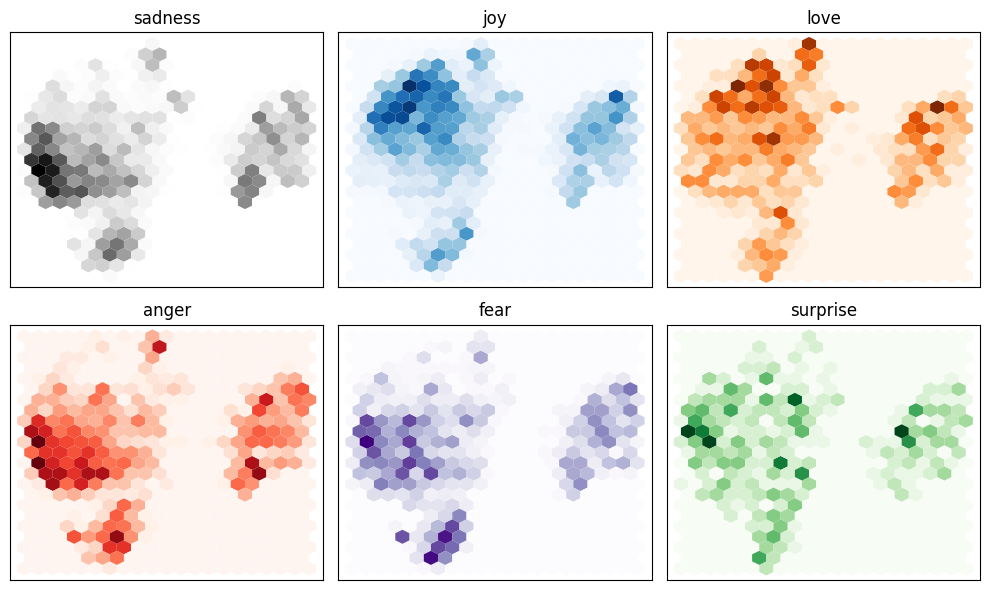

In [33]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], 
                   gridsize=20, linewidths=0, cmap=cmap)
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [34]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid,y_valid)

0.633

In [35]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

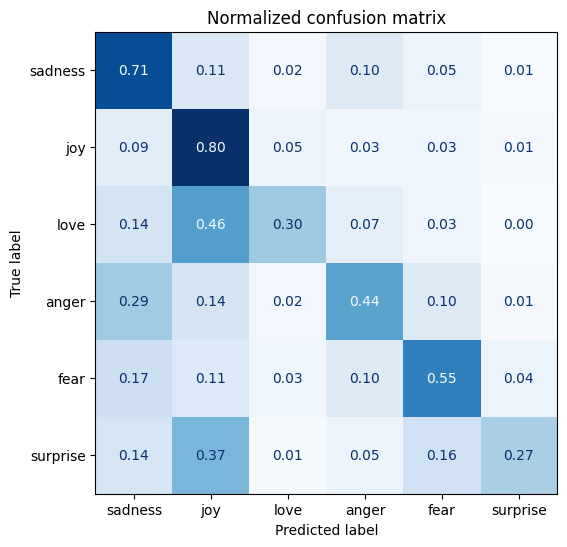

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
     cm = confusion_matrix(y_true, y_preds, normalize="true")
     fig, ax = plt.subplots(figsize=(6, 6))
     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
     disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
     plt.title("Normalized confusion matrix")
     plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [37]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
from sklearn.metrics import accuracy_score,f1_score

def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels,preds, average="weighted")
    acc = accuracy_score(labels,preds)
    return {"accuracy" : acc, "f1-score" : f1}

In [39]:
from huggingface_hub import notebook_login

notebook_login()

In [40]:
import transformers
print(transformers.__version__)

4.41.1


In [41]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                     num_train_epochs=2,
                                     learning_rate=2e-5,
                                     per_device_train_batch_size=batch_size,
                                     per_device_eval_batch_size=batch_size,
                                     weight_decay=0.01,
                                     evaluation_strategy="epoch",
                                     disable_tqdm=False,
                                     logging_steps=logging_steps,
                                     push_to_hub=True,
                                     log_level="error")

trainer = Trainer(model=model, args=training_args,
                     compute_metrics=compute_metrics,
                     train_dataset=emotions_encoded["train"],
                     eval_dataset=emotions_encoded["validation"],
                     tokenizer=tokenizer)
                     
trainer.train()

C:\Users\Manav\my_env\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-score
1,0.821900,0.308541,0.908000,0.905167
2,0.250400,0.221165,0.923500,0.923150


TrainOutput(global_step=500, training_loss=0.5361262741088867, metrics={'train_runtime': 163.6068, 'train_samples_per_second': 195.591, 'train_steps_per_second': 3.056, 'total_flos': 720342861696000.0, 'train_loss': 0.5361262741088867, 'epoch': 2.0})

In [42]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [43]:
preds_output.metrics

{'test_loss': 0.22116534411907196,
 'test_accuracy': 0.9235,
 'test_f1-score': 0.9231497048018283,
 'test_runtime': 2.5185,
 'test_samples_per_second': 794.109,
 'test_steps_per_second': 12.706}

In [44]:
y_preds = np.argmax(preds_output.predictions, axis=1)

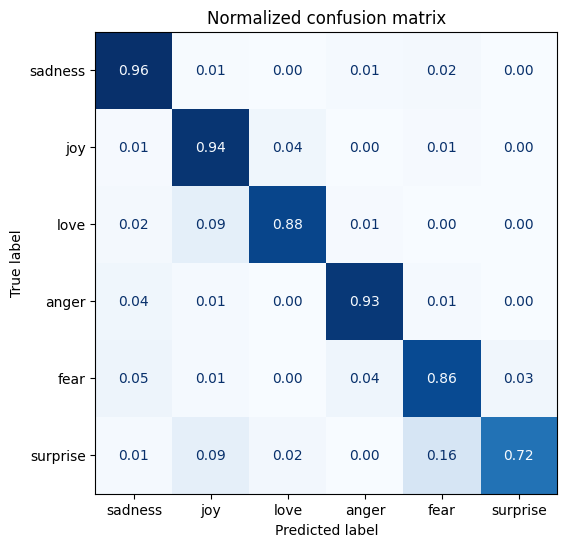

In [45]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [49]:
import torch
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {
        "loss": loss.cpu().numpy(),
        "predicted_label": pred_label.cpu().numpy()
    }

In [50]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
 # Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [51]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [52]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.715846
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.618932
1801,i feel that he was being overshadowed by the s...,love,sadness,5.513777
1274,i am going to several holiday parties and i ca...,joy,sadness,5.478921
882,i feel badly about reneging on my commitment t...,love,sadness,5.314689
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.266997
1509,i guess this is a memoir so it feels like that...,joy,fear,4.945472
765,i feel super awkward and out of place right now,joy,sadness,4.922913
465,i would eventually go in to these stores but i...,joy,fear,4.698392
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.560731


In [53]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.016826
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.016915
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.016990
716,im feeling pretty cool calm and collected and ...,joy,joy,0.017229
578,i got to christmas feeling positive about the ...,joy,joy,0.017299
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.017338
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.017432
394,i feel shamed that i hoped for one last christ...,sadness,sadness,0.017568
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0.017685
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.017687


In [54]:
trainer.push_to_hub(commit_message="Training completed!")

CommitInfo(commit_url='https://huggingface.co/Manav13254/distilbert-base-uncased-finetuned-emotion/commit/6e4a352fd3b6fcf3926b3894beb9203734ef217b', commit_message='Training completed!', commit_description='', oid='6e4a352fd3b6fcf3926b3894beb9203734ef217b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Manav13254/distilbert-base-uncased-finetuned-emotion', endpoint='https://huggingface.co', repo_type='model', repo_id='Manav13254/distilbert-base-uncased-finetuned-emotion'), pr_revision=None, pr_num=None)